In [ ]:
pip install statsmodels --upgrade

In [ ]:
pip install pmdarima

In [ ]:
!pip install matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from pmdarima import auto_arima

# for metric
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot,quarter_plot

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Data/Data IPM Jawa Tengah Python.xlsx', parse_dates=['Tahun'])
df.set_index('Tahun', inplace=True)

In [ ]:
df

,Kabupaten/Kota,UHH,HLS,RLS,PPK,IPM
Tahun,,,,,,
2010-01-01,Kabupaten Cilacap,72.45,10.56,6.26,8520.27,64.18
2011-01-01,Kabupaten Cilacap,72.55,10.71,6.27,8800.85,64.73
2012-01-01,Kabupaten Cilacap,72.65,11.34,6.28,8969.12,65.72
2013-01-01,Kabupaten Cilacap,72.75,11.98,6.43,9070.61,66.80
2014-01-01,Kabupaten Cilacap,72.80,12.27,6.48,9091.04,67.25
...,...,...,...,...,...,...
2018-01-01,Kota Tegal,74.30,12.90,8.30,12830.00,74.44
2019-01-01,Kota Tegal,74.34,13.04,8.31,13250.00,74.93
2020-01-01,Kota Tegal,74.46,13.05,8.51,12999.00,75.07


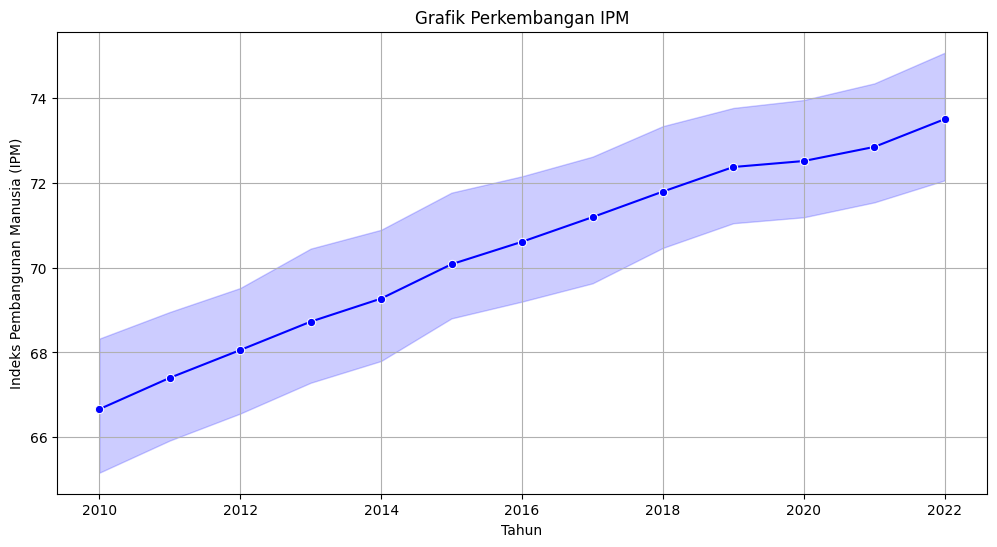

In [ ]:
# Memvisualisasikan data IPM menggunakan line plot
plt.figure(figsize=(12, 6))
sns.lineplot(df['IPM'], marker='o', color='b')
plt.xlabel('Tahun')
plt.ylabel('Indeks Pembangunan Manusia (IPM)')
plt.title('Grafik Perkembangan IPM')
plt.grid(True)

# Menyimpan gambar visualisasi
plt.savefig('ipm.jpeg', format='jpeg')

plt.show()

In [ ]:
# Melakukan sorting berdasarkan indeks (tahun)
df.sort_index(inplace=True)

# Kita akan menggunakan data dari tahun sebelum 2023 sebagai data latih dan data pada tahun 2023 sebagai data uji.
train_data = df[df.index < '2022-01-01']
test_data = df[df.index >= '2022-01-01']

print("Jumlah data latih:", len(train_data))
print("Jumlah data uji:", len(test_data))

print("\nData Latih (Training Set):")
print(train_data.head())

print("\nData Uji (Testing Set):")
print(test_data.head())

Jumlah data latih: 420
Jumlah data uji: 35

Data Latih (Training Set):
                Kabupaten/Kota    UHH    HLS   RLS       PPK    IPM
Tahun                                                              
2010-01-01   Kabupaten Cilacap  72.45  10.56  6.26   8520.27  64.18
2010-01-01  Kabupaten Boyolali  75.41  11.11  6.50  10840.22  68.76
2010-01-01     Kabupaten Tegal  70.32  10.61  5.67   7429.03  61.14
2010-01-01     Kabupaten Blora  73.51  10.75  5.48   7965.99  63.02
2010-01-01     Kabupaten Demak  75.05  10.98  6.56   8420.51  66.02

Data Uji (Testing Set):
                   Kabupaten/Kota    UHH    HLS   RLS      PPK    IPM
Tahun                                                                
2022-01-01     Kabupaten Semarang  75.86  13.04  8.05  12448.0  74.67
2022-01-01  Kabupaten Karanganyar  77.64  13.70  8.79  11798.0  76.58
2022-01-01        Kota Pekalongan  74.51  12.86  9.20  13158.0  75.90
2022-01-01      Kabupaten Cilacap  74.07  12.66  7.18  10904.0  70.99
2022-01-

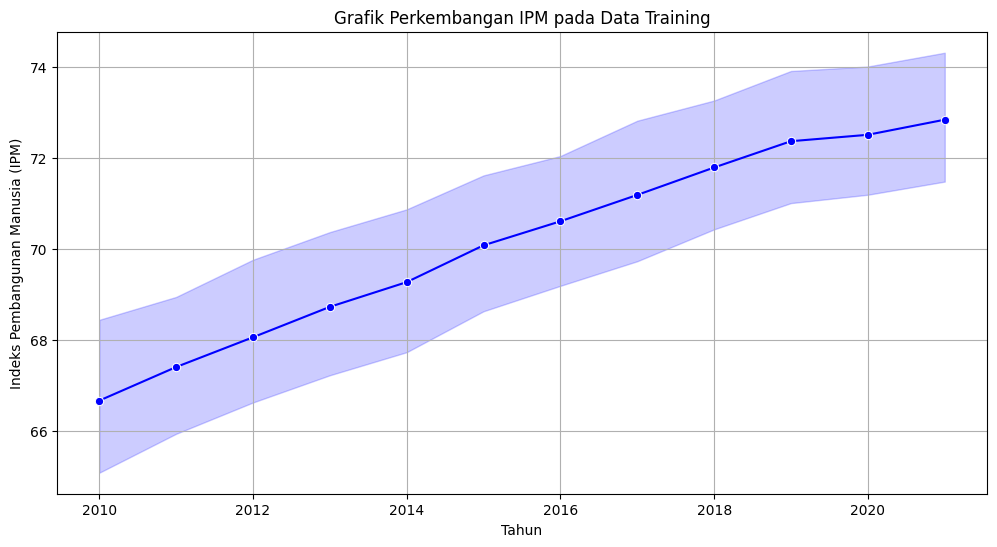

In [ ]:
# Memvisualisasikan data IPM menggunakan line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data['IPM'], marker='o', color='b')
plt.xlabel('Tahun')
plt.ylabel('Indeks Pembangunan Manusia (IPM)')
plt.title('Grafik Perkembangan IPM pada Data Training')
plt.grid(True)
plt.show()

In [ ]:
# Cek staionarity pada dataset training
adf = adfuller(train_data['IPM'])

# Print hasil cek staionarity
print('ADF Statistic:', adf[0])
print('p-value:', adf[1])

# Jika p-value < 0.05, maka dataset stasioner
if adf[1] < 0.05:
    print('Dataset stasioner')
else:
    print('Dataset tidak stasioner')

ADF Statistic: -3.634714847011467
p-value: 0.00513100266475423
Dataset stasioner


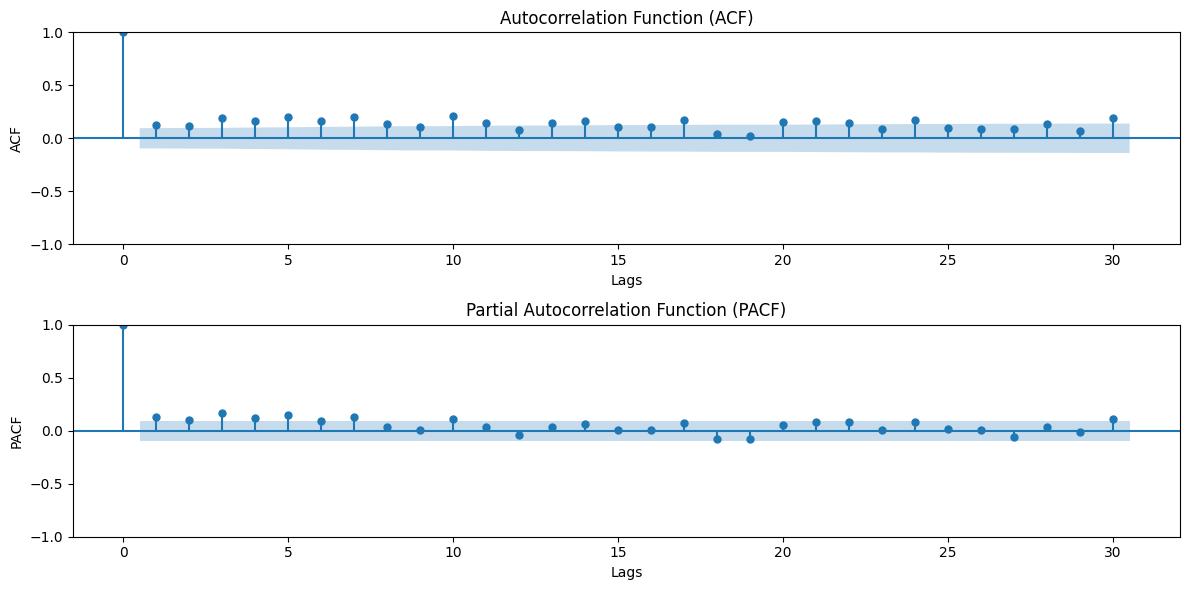

In [ ]:
# Menghitung dan memvisualisasikan ACF dan PACF dengan lags 30
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(train_data['IPM'], lags=30, ax=plt.gca())
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_pacf(train_data['IPM'], lags=30, ax=plt.gca())
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)

# Menerapkan model ARIMA dengan berbagai kombinasi parameter
results = []
for i in p:
    for j in d:
        for k in q:
            model = sm.tsa.ARIMA(train_data['IPM'], order=(i,j,k))
            model = model.fit()
            results.append([i,j,k,model.aic])

# Mencari best order
best_order = results[0]
for i in results:
    if i[3] < best_order[3]:
        best_order = i

# Menampilkan hasil
print('Best Order | AIC')
print(best_order)

Best Order | AIC
[3, 1, 4, 2473.894517285416]


In [ ]:
# Menentukan parameter model ARIMA
model = sm.tsa.ARIMA(train_data['IPM'], order=(3,1,4))

# Melatih model ARIMA
model = model.fit()

# Menampilkan hasil pelatihan model ARIMA
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                    IPM   No. Observations:                  420
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -1228.947
Date:                Mon, 31 Jul 2023   AIC                           2473.895
Time:                        03:48:35   BIC                           2506.197
Sample:                             0   HQIC                          2486.663
                                - 420                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4964      0.058    -25.856      0.000      -1.610      -1.383
ar.L2         -1.4902      0.035    -42.581      0.000      -1.559      -1.422
ar.L3         -0.9816      0.054    -18.086      0.0

In [ ]:
# Mendapatkan daftar unik Kabupaten/Kota
kabupaten_list = train_data['Kabupaten/Kota'].unique()

# Menerapkan model ARIMA untuk setiap Kabupaten/Kota dan melakukan prediksi 5 tahun ke depan
predictions = []
for kabupaten in kabupaten_list:
    # Filter data training untuk Kabupaten/Kota tertentu
    kabupaten_data = train_data[train_data['Kabupaten/Kota'] == kabupaten]['IPM']

    # Menerapkan model ARIMA dengan parameter (3,1,4) untuk Kabupaten/Kota tertentu
    model = sm.tsa.ARIMA(kabupaten_data, order=(3, 1, 4))
    model_fit = model.fit()

    # Melakukan prediksi untuk 5 tahun ke depan
    forecast = model_fit.forecast(steps=5)

    # Menambahkan hasil prediksi ke dalam list predictions
    predictions.append({
        'Kabupaten/Kota': kabupaten,
        'IPM_Forecast': forecast.tolist(),
    })

# Menampilkan hasil prediksi untuk setiap Kabupaten/Kota
for prediction in predictions:
    kabupaten = prediction['Kabupaten/Kota']
    ipm_forecast = prediction['IPM_Forecast']
    print(f"Prediksi IPM untuk {kabupaten}: {ipm_forecast}")

Prediksi IPM untuk Kabupaten Cilacap: [70.89784524314273, 70.83617040994787, 71.15756267850503, 71.46116804021037, 71.49293725824094]
Prediksi IPM untuk Kabupaten Boyolali: [74.49251477458435, 74.54041464721277, 74.52290021737474, 74.48161953289292, 74.43525923376689]
Prediksi IPM untuk Kabupaten Tegal: [69.27294117729505, 69.18422113808364, 69.19602289933613, 69.45502576632768, 69.39662042114918]
Prediksi IPM untuk Kabupaten Blora: [69.8279667830286, 70.43930222448687, 70.95031282874078, 71.56236160400039, 72.07364627714531]
Prediksi IPM untuk Kabupaten Demak: [73.2306584977107, 73.6751956840132, 74.0553933010854, 74.59385978975277, 75.05733654849519]
Prediksi IPM untuk Kota Semarang: [83.58448220867217, 84.07163732001484, 84.56117628421504, 85.05131140236381, 85.54221147127672]
Prediksi IPM untuk Kabupaten Wonosobo: [68.86520184676677, 69.22447526966135, 69.40575783912253, 69.45625002032477, 69.52895777300454]
Prediksi IPM untuk Kabupaten Batang: [69.39731594790794, 69.94442998989085

In [ ]:
# Inisialisasi list untuk menyimpan hasil evaluasi
evaluation_results = []

# Menerapkan model ARIMA untuk setiap Kabupaten/Kota dan melakukan prediksi pada data uji
for kabupaten in kabupaten_list:
    # Filter data training dan data uji untuk Kabupaten/Kota tertentu
    kabupaten_train_data = train_data[train_data['Kabupaten/Kota'] == kabupaten]['IPM']
    kabupaten_test_data = test_data[test_data['Kabupaten/Kota'] == kabupaten]['IPM']

    # Menerapkan model ARIMA dengan parameter (3,1,4) untuk Kabupaten/Kota tertentu
    model = sm.tsa.ARIMA(kabupaten_train_data, order=(3, 1, 4))
    model_fit = model.fit()

    # Melakukan prediksi pada data uji
    forecast = model_fit.forecast(steps=len(kabupaten_test_data))

    # Menghitung RMSE dan MAE
    rmse = np.sqrt(mean_squared_error(kabupaten_test_data, forecast))
    mae = mean_absolute_error(kabupaten_test_data, forecast)

    # Menambahkan hasil evaluasi ke dalam list evaluation_results
    evaluation_results.append({
        'Kabupaten/Kota': kabupaten,
        'RMSE': rmse,
        'MAE': mae,
    })

# Menampilkan hasil evaluasi untuk setiap Kabupaten/Kota
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

,Kabupaten/Kota,RMSE,MAE
0,Kabupaten Cilacap,0.092155,0.092155
1,Kabupaten Boyolali,0.477485,0.477485
2,Kabupaten Tegal,0.257059,0.257059
3,Kabupaten Blora,0.122033,0.122033
4,Kabupaten Demak,0.129342,0.129342
5,Kota Semarang,0.495518,0.495518
6,Kabupaten Wonosobo,0.024798,0.024798
7,Kabupaten Batang,0.052684,0.052684
8,Kabupaten Wonogiri,0.237670,0.237670
9,Kabupaten Grobogan,0.028740,0.028740


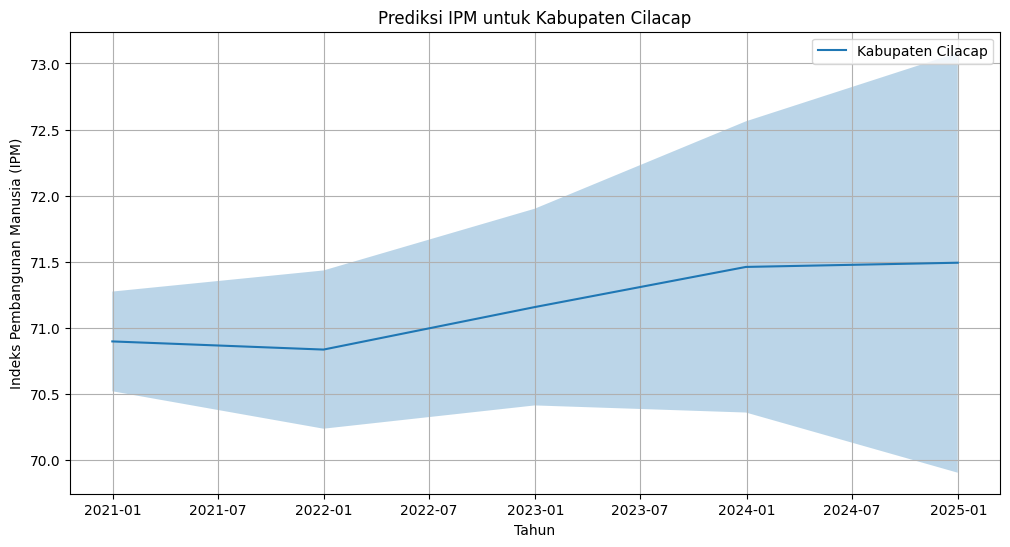

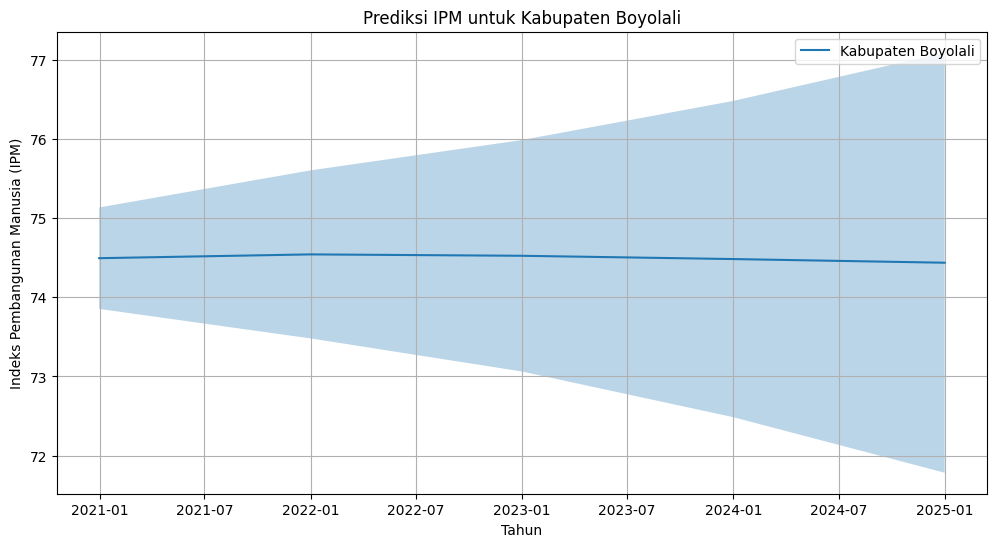

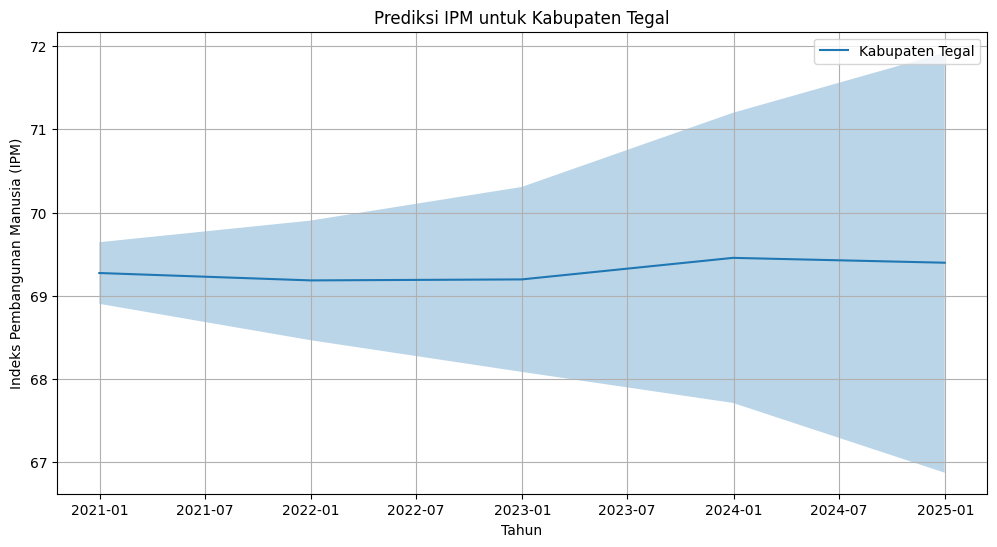

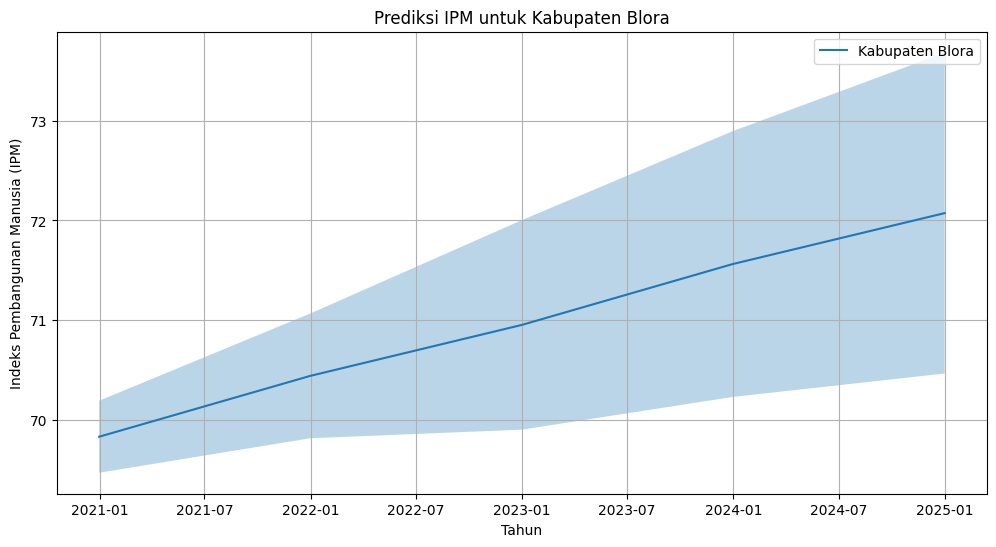

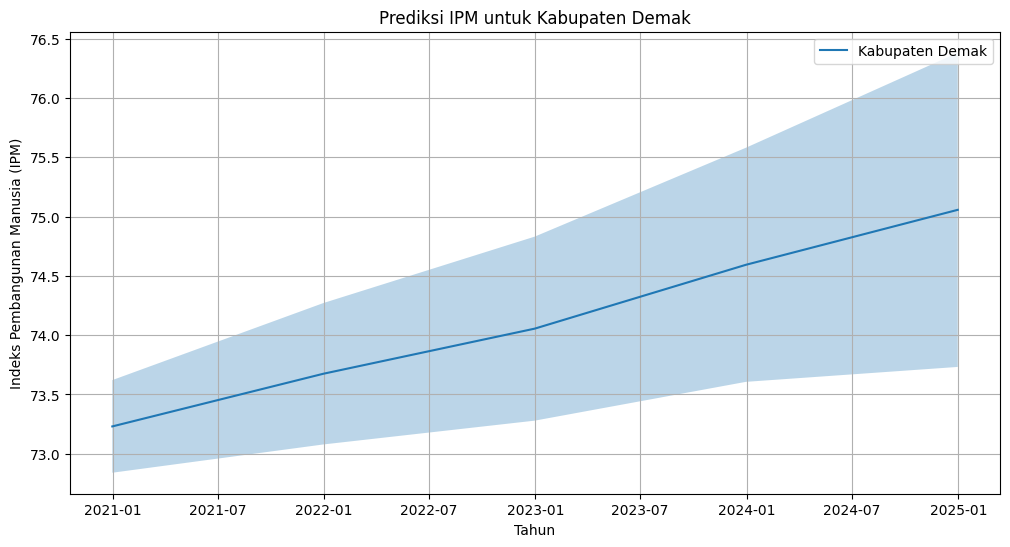

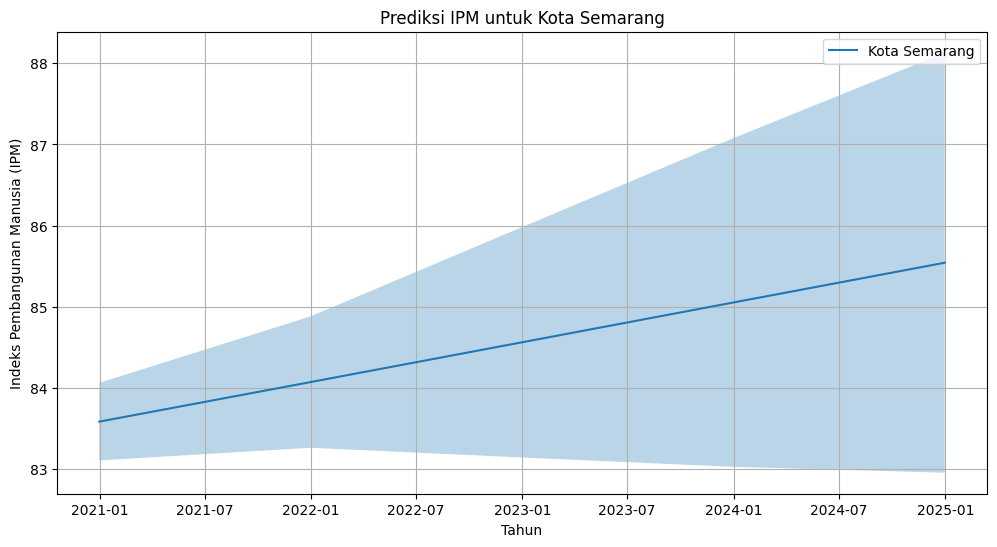

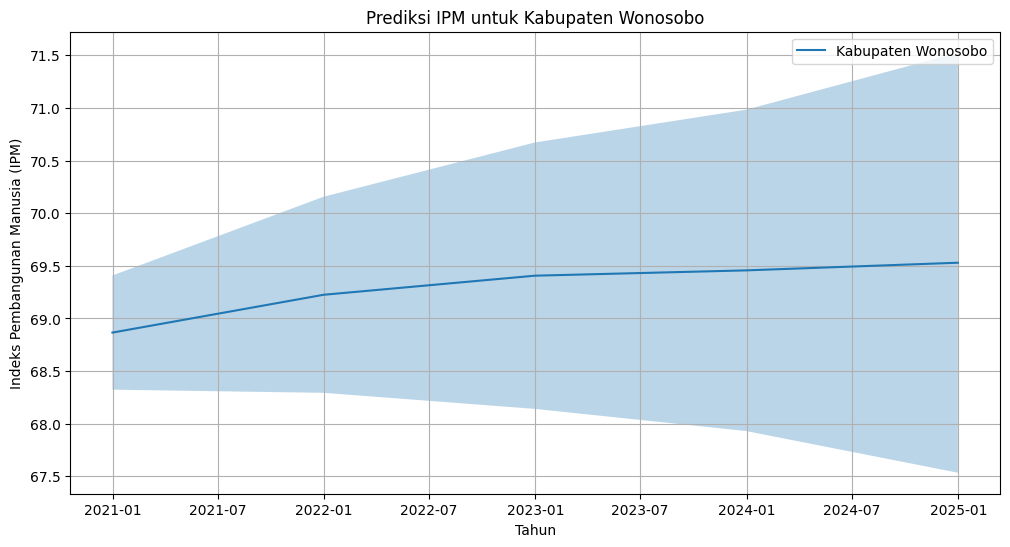

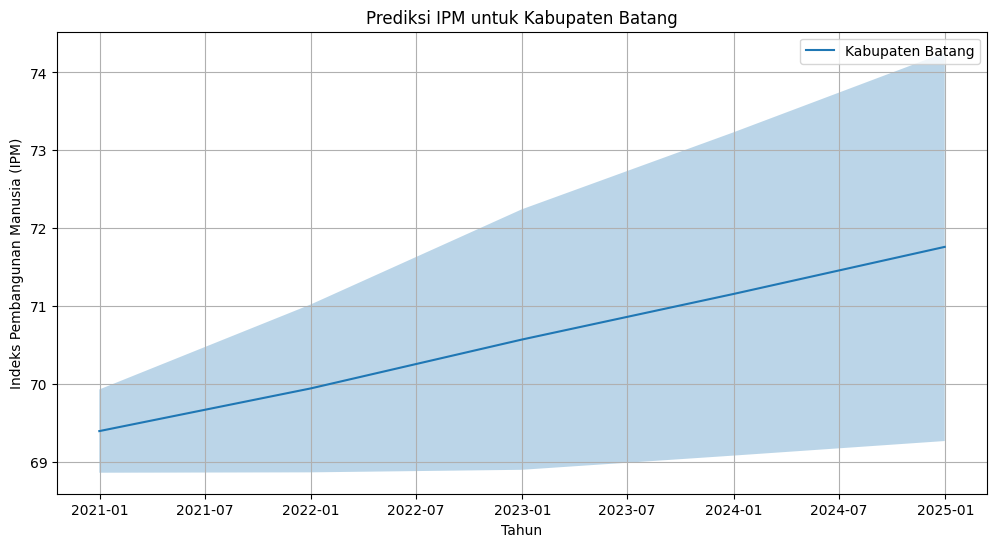

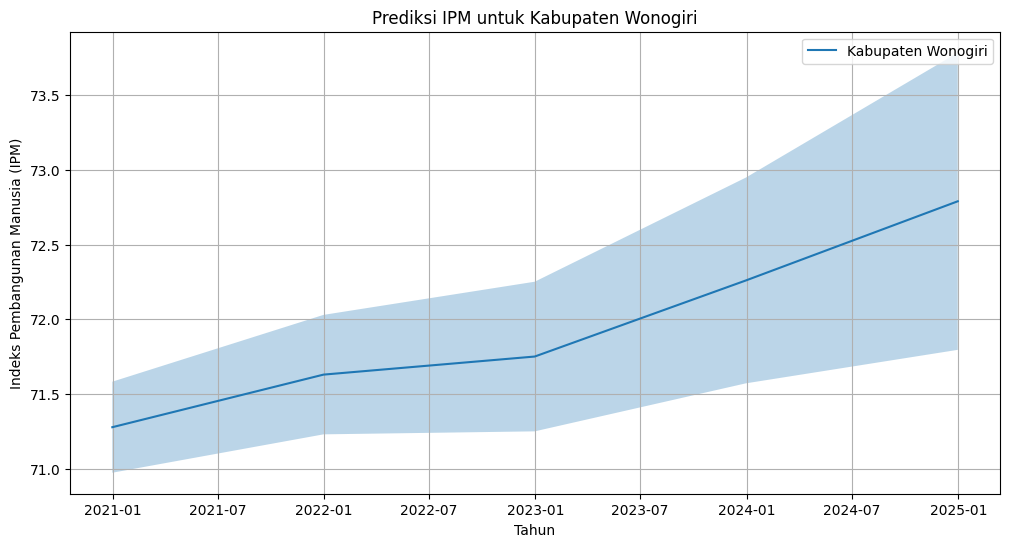

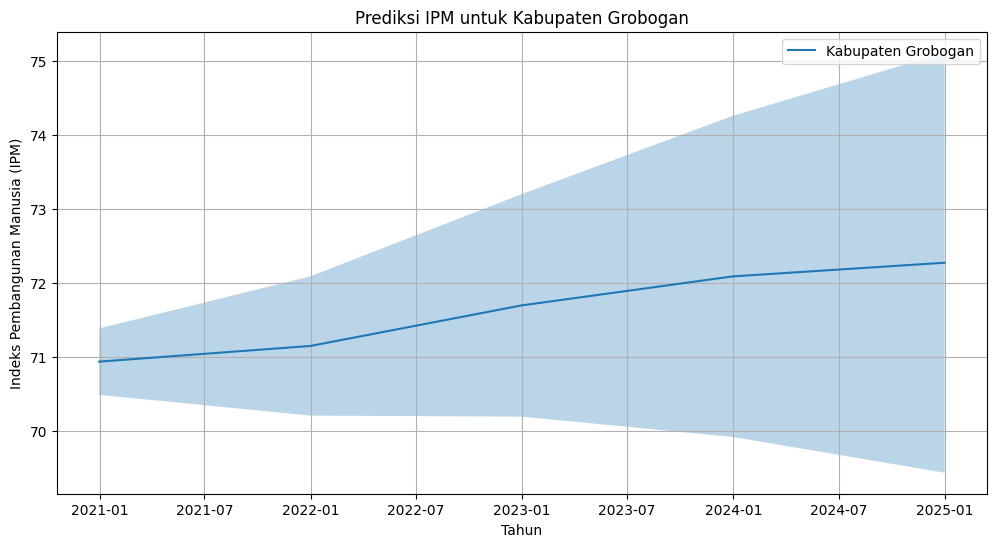

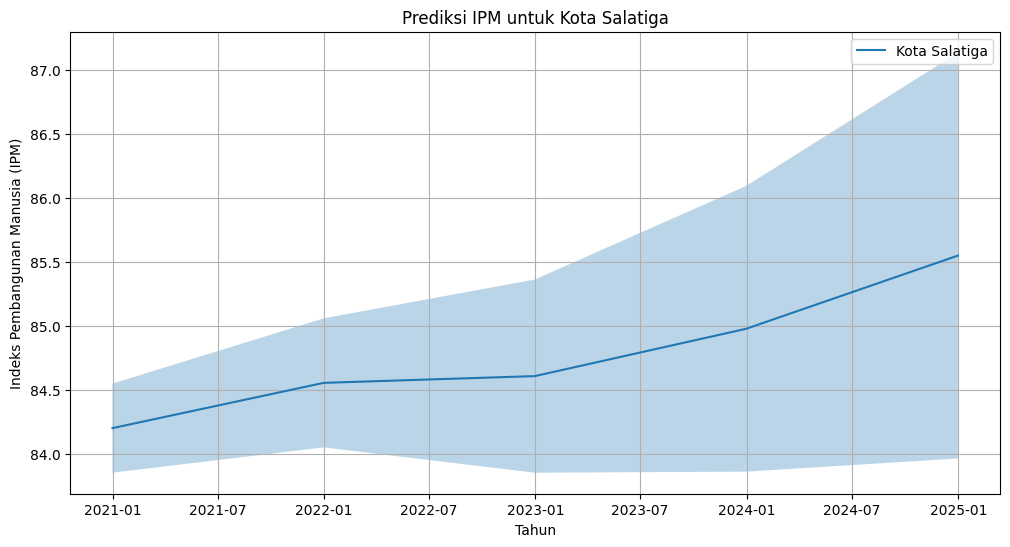

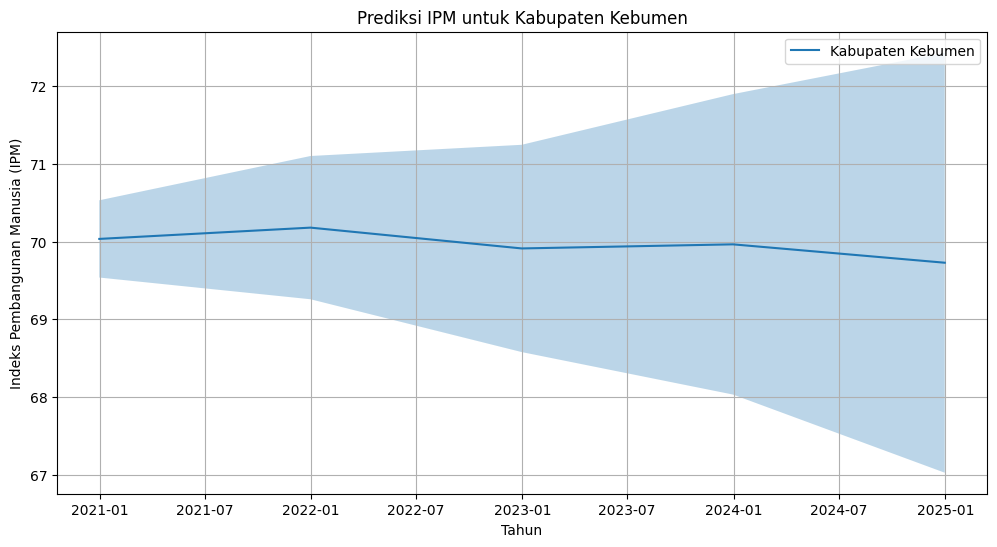

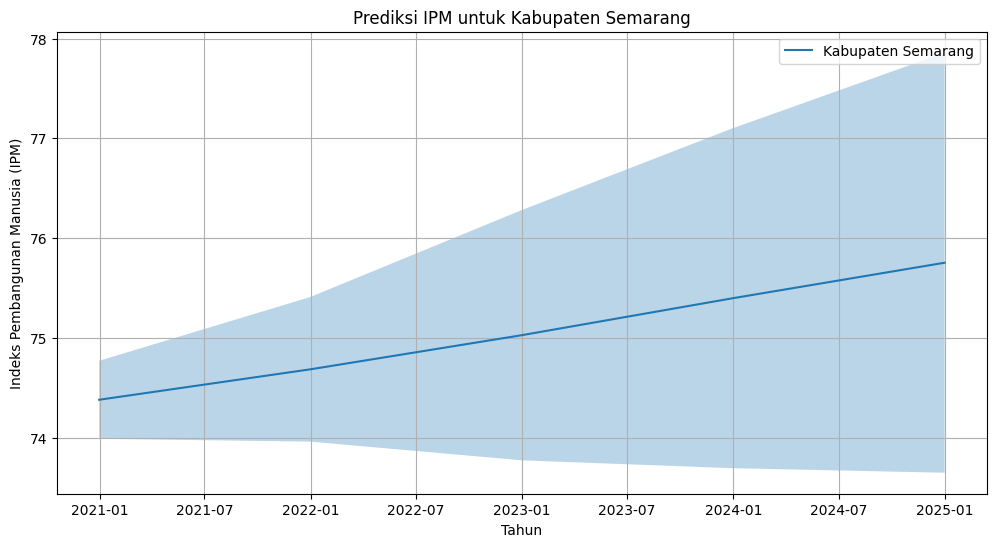

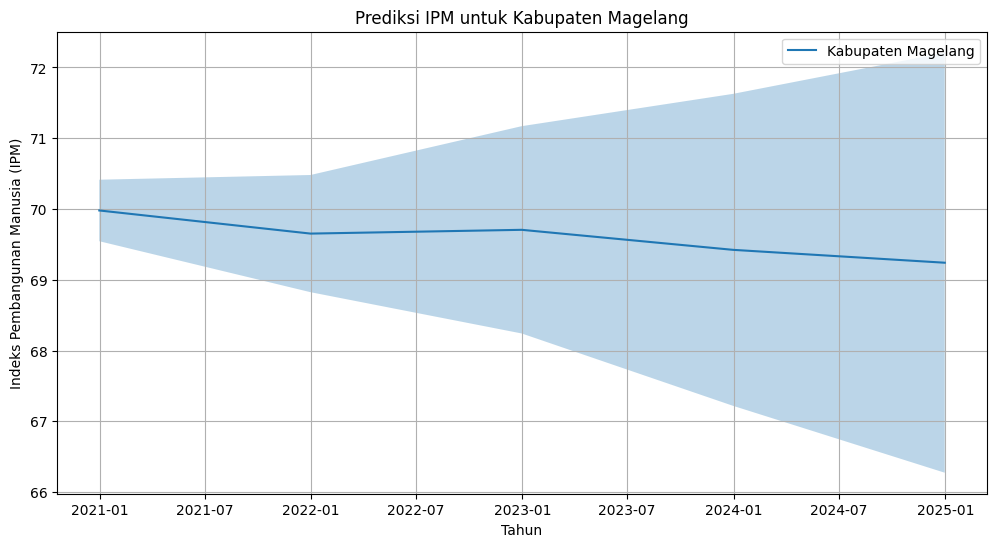

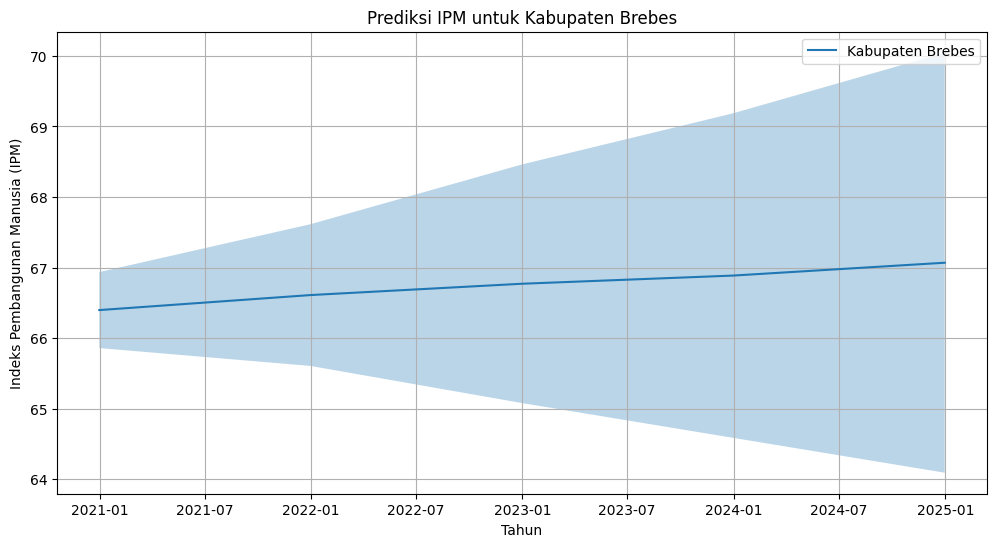

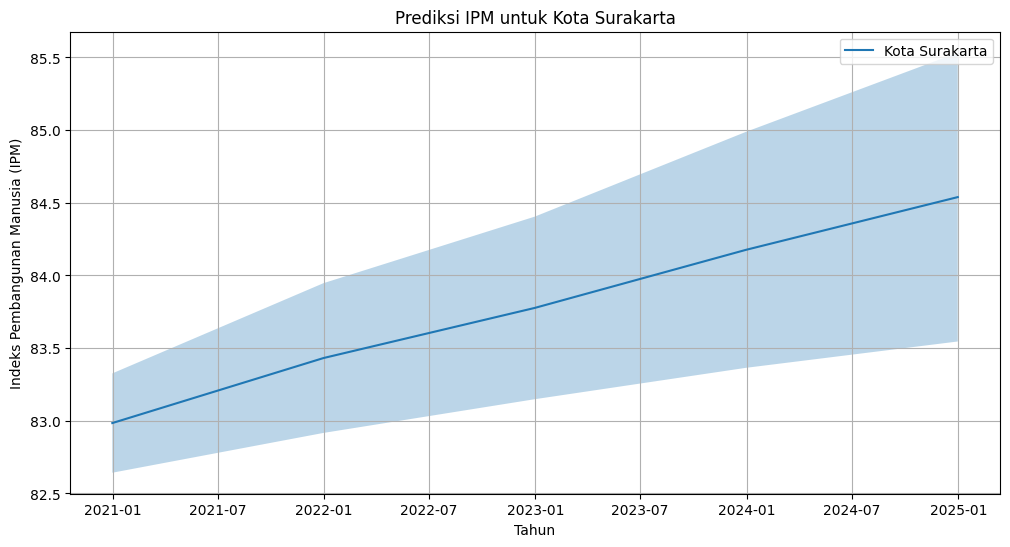

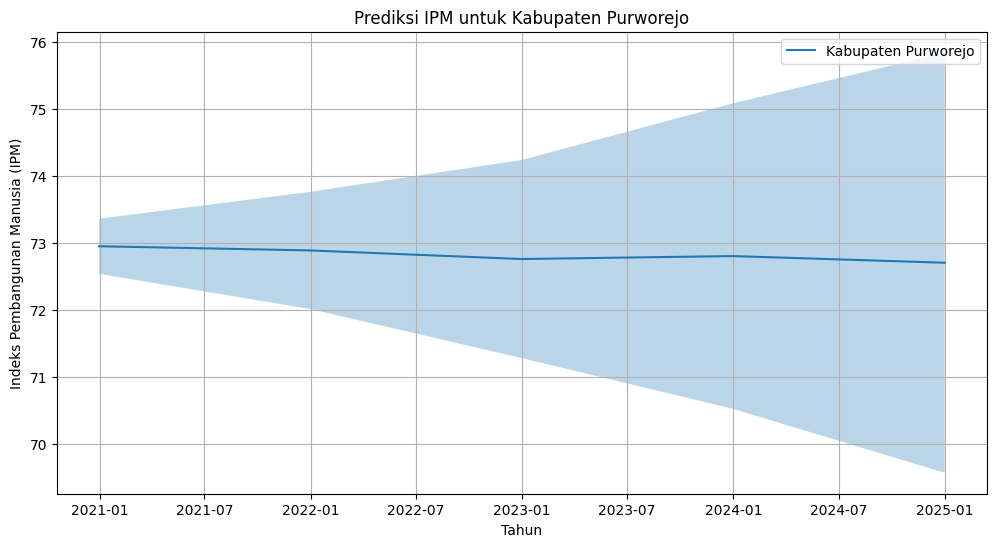

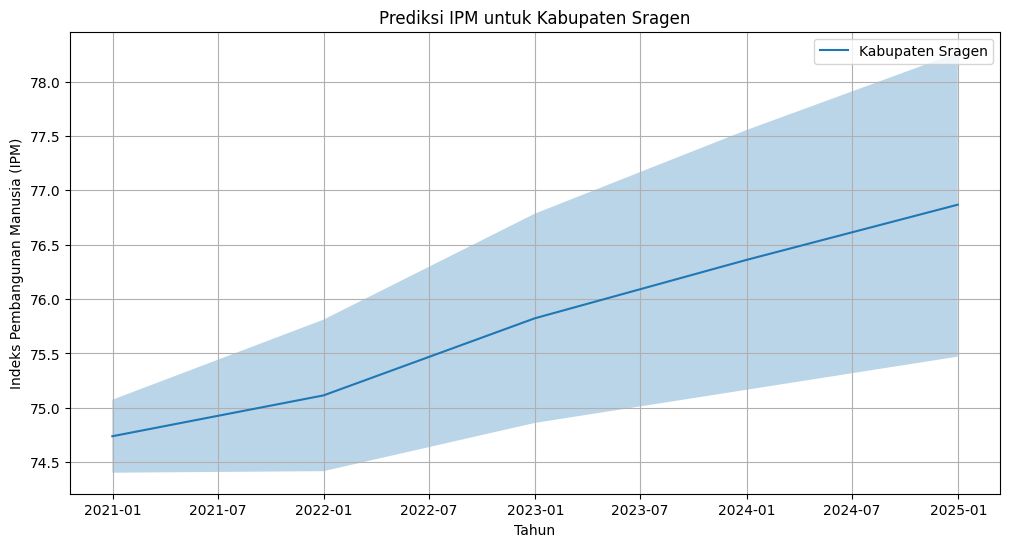

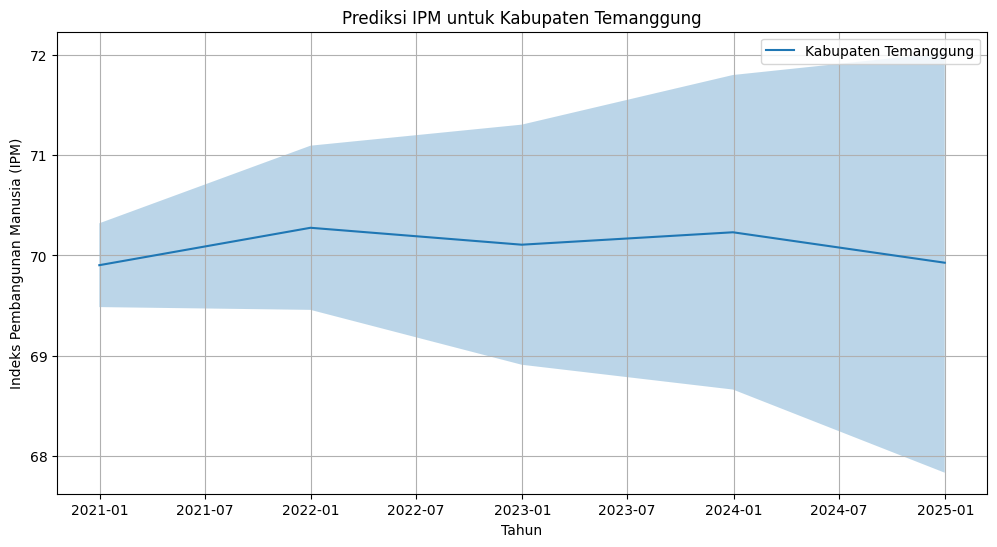

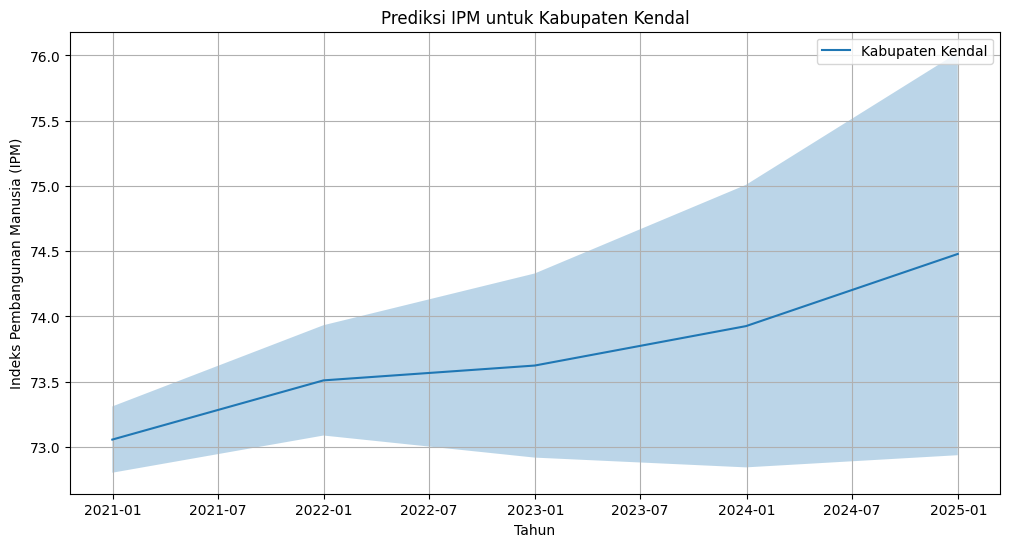

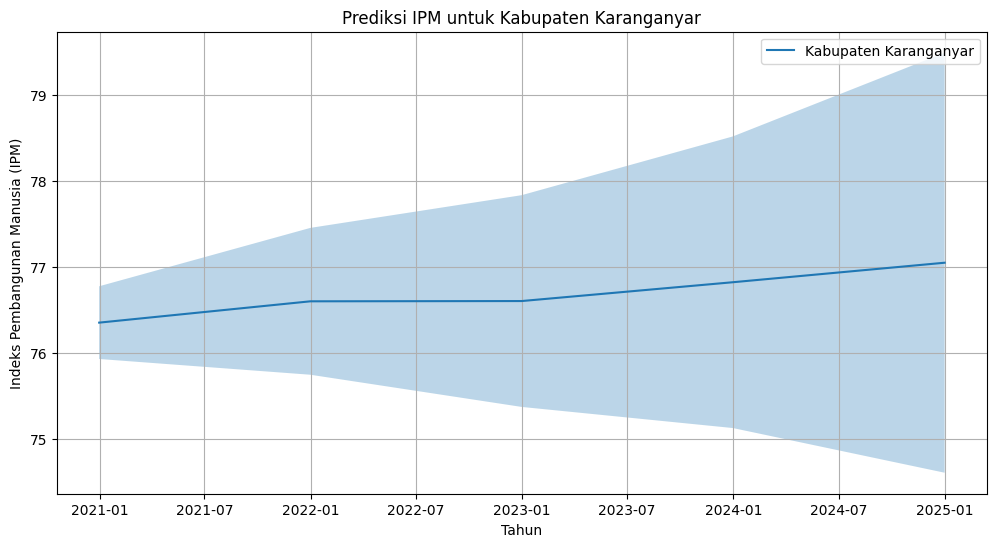

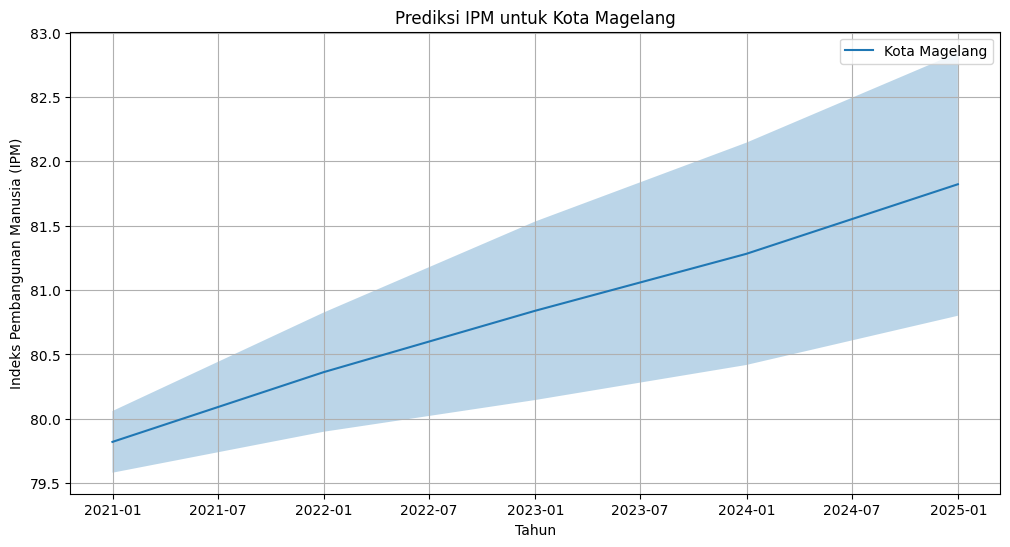

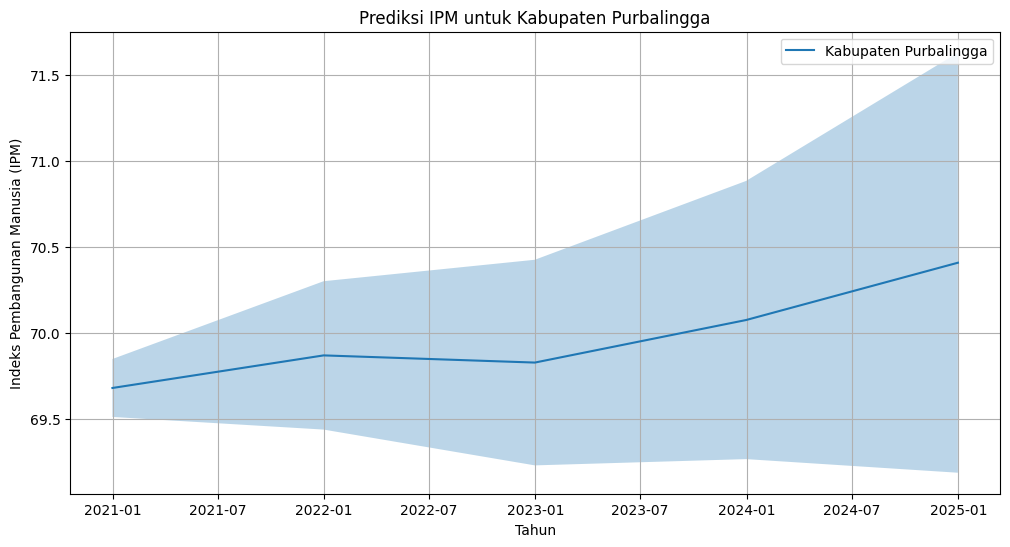

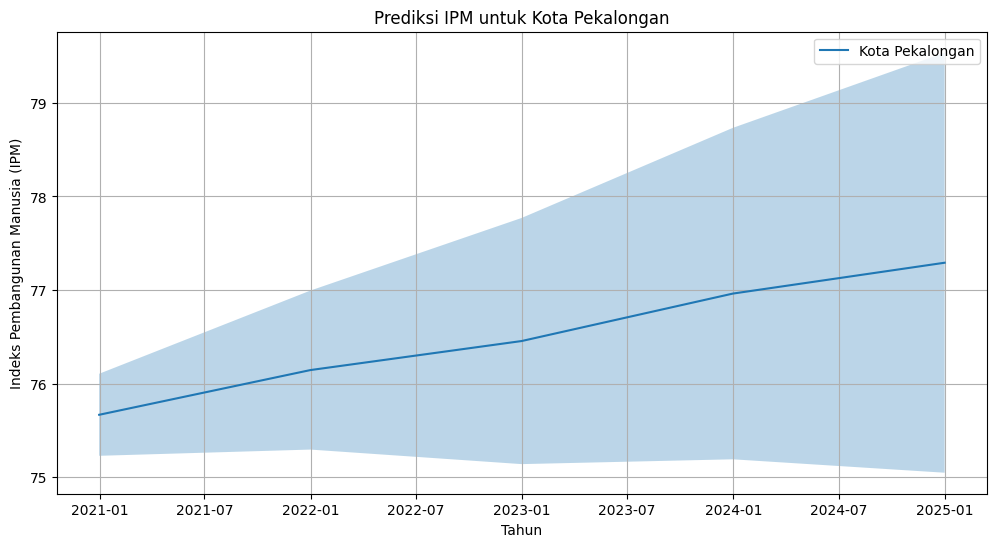

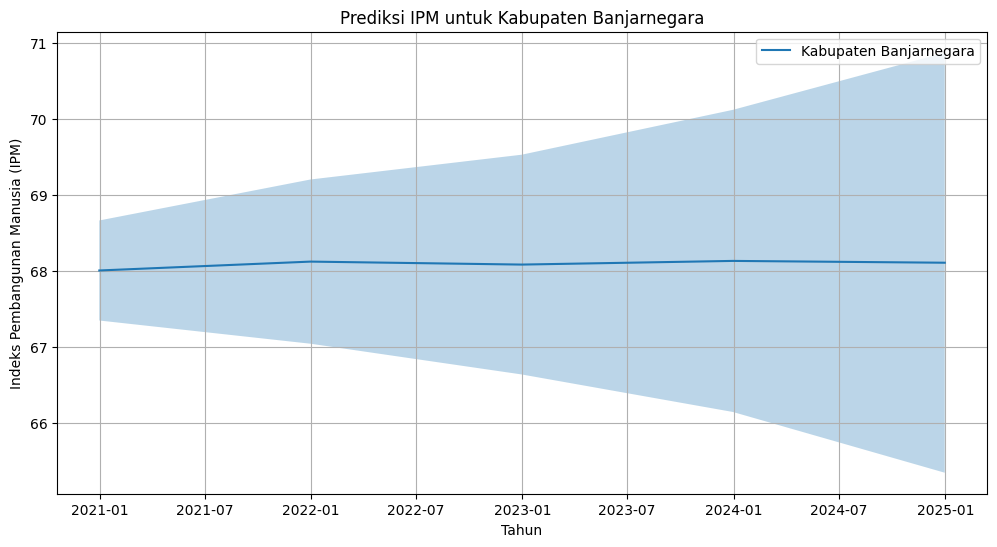

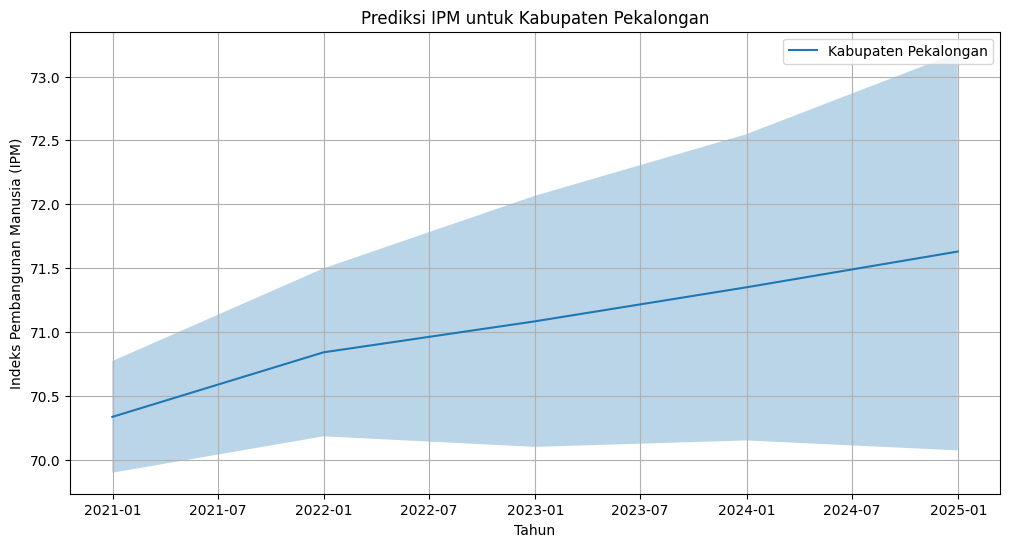

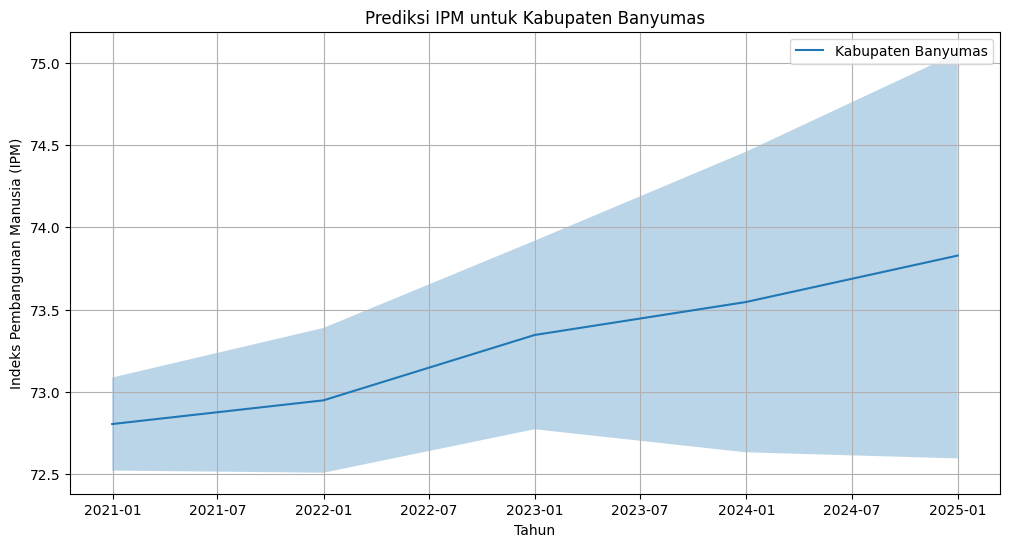

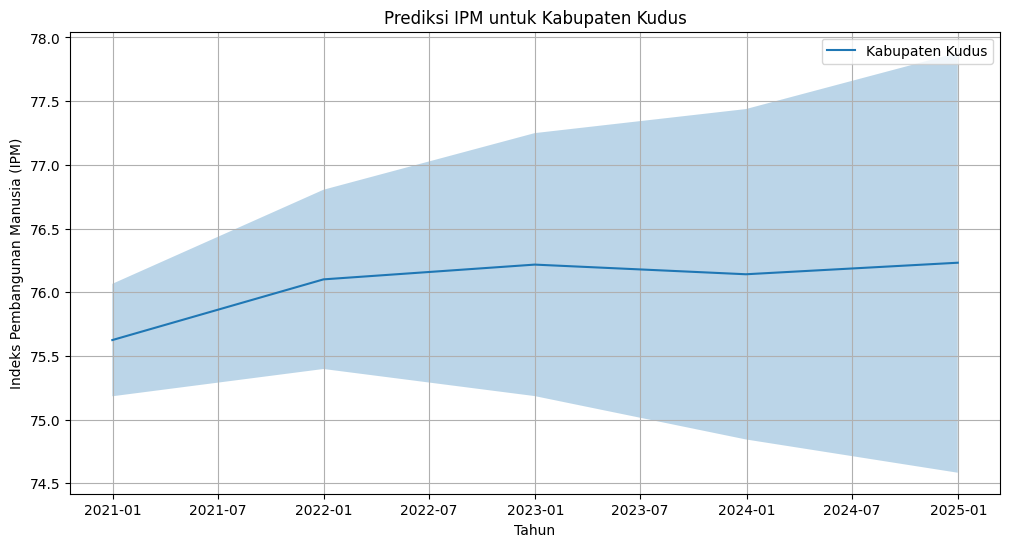

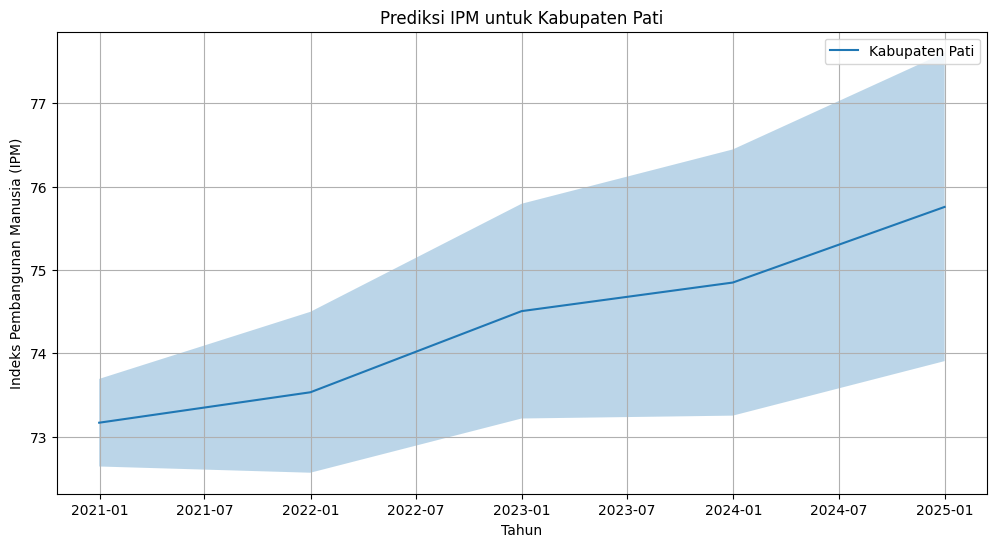

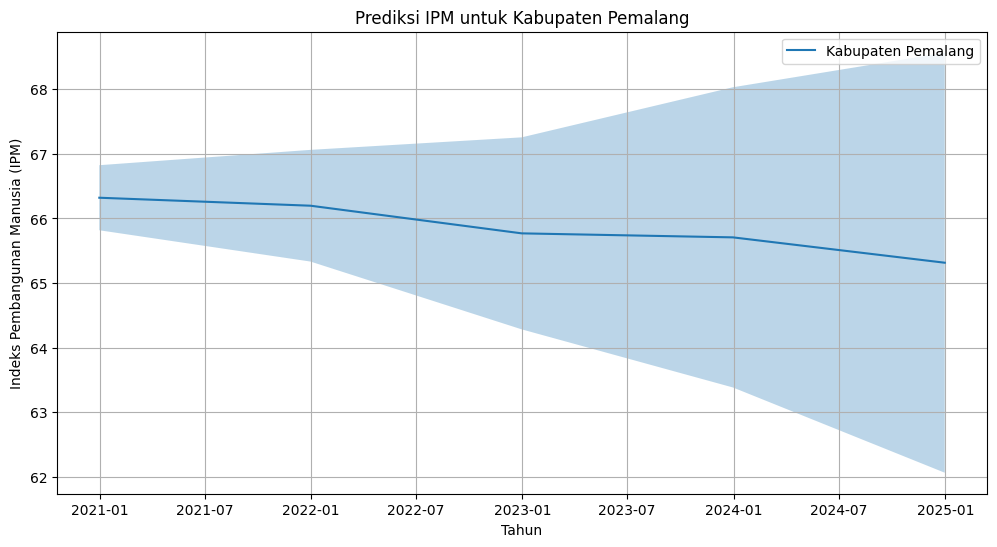

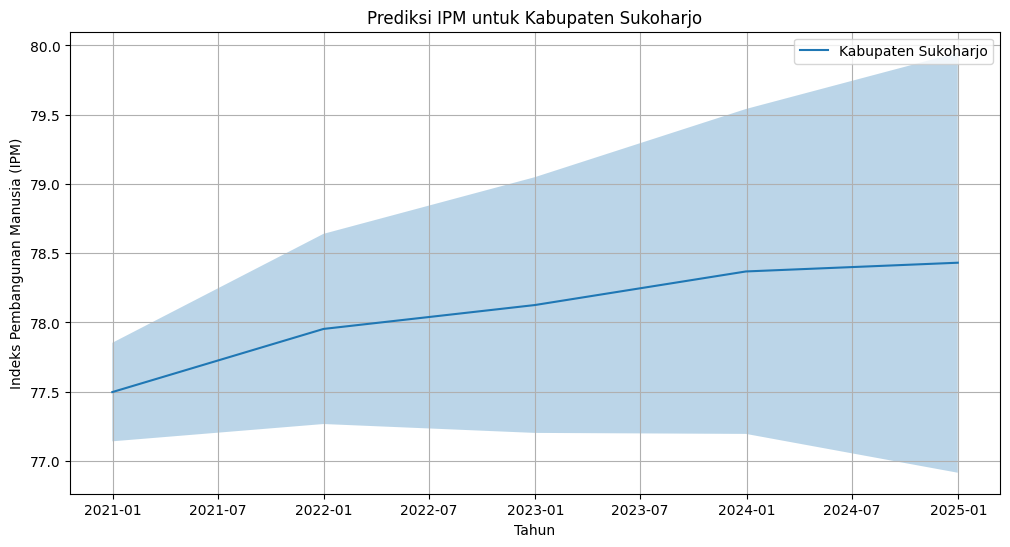

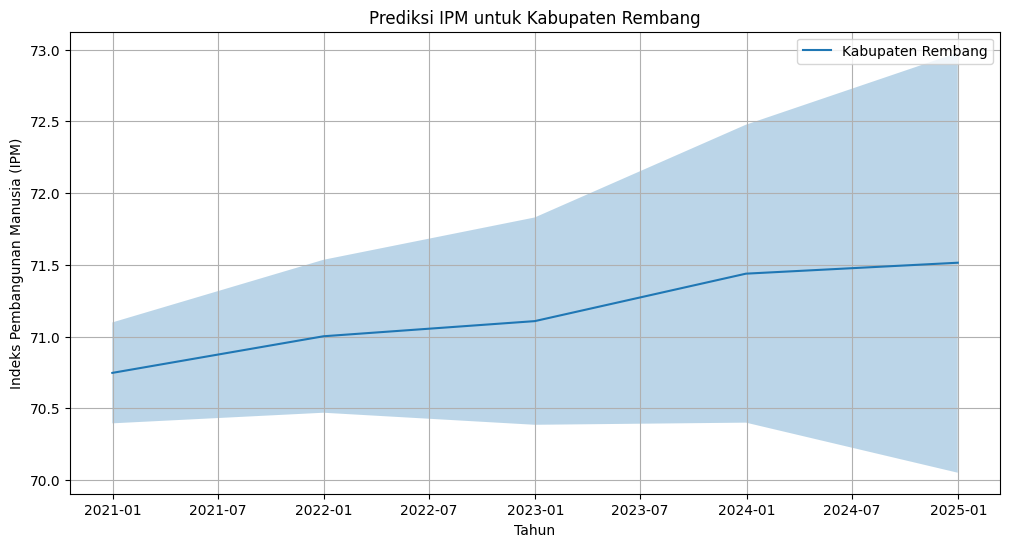

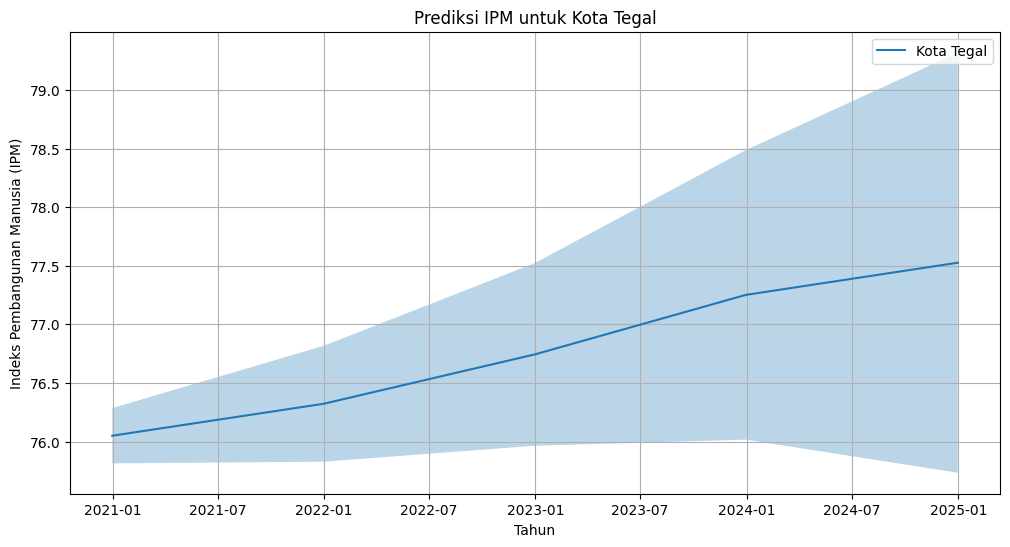

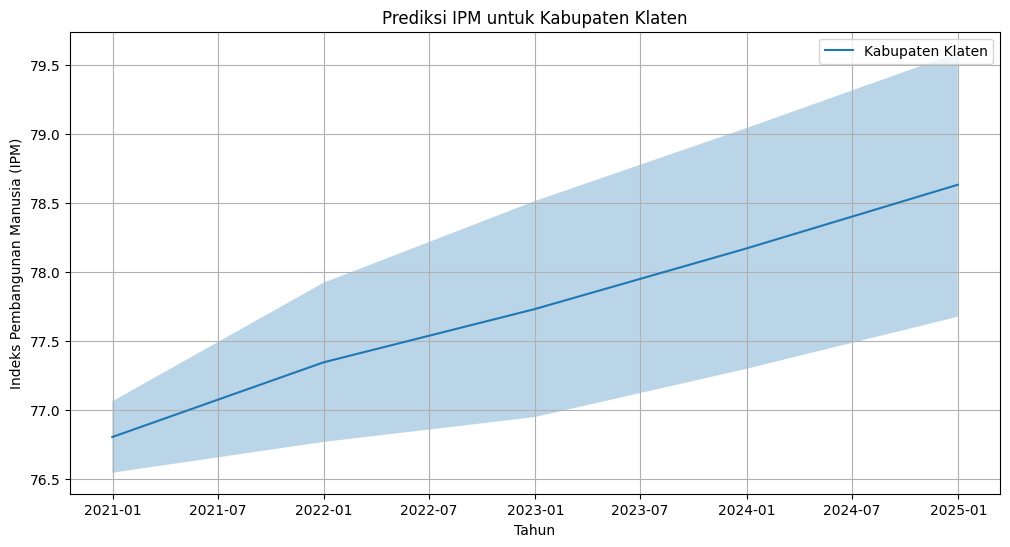

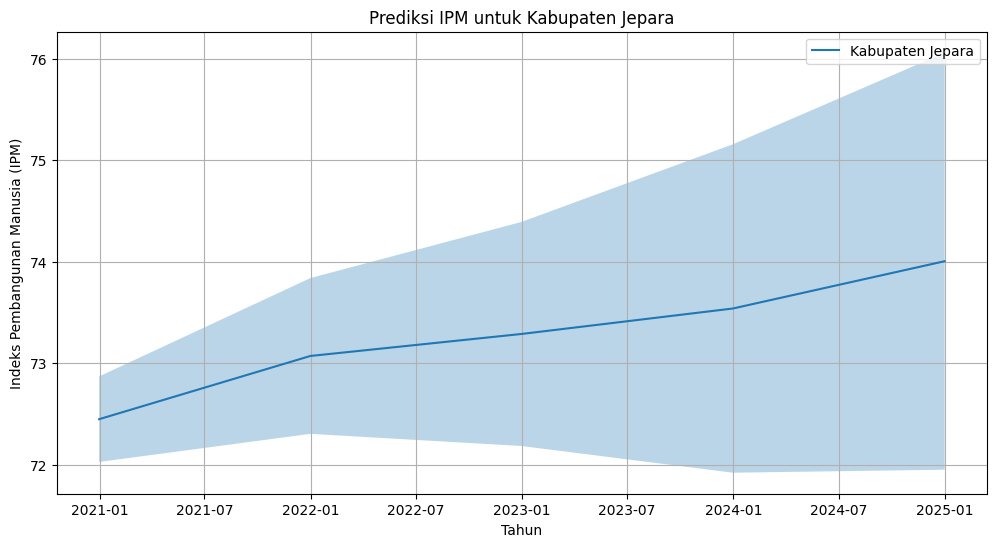

In [ ]:
# Mendapatkan daftar unik Kabupaten/Kota
kabupaten_list = train_data['Kabupaten/Kota'].unique()

# Menerapkan model ARIMA untuk setiap Kabupaten/Kota dan melakukan prediksi 5 tahun ke depan
for kabupaten in kabupaten_list:
    # Filter data training untuk Kabupaten/Kota tertentu
    kabupaten_data = train_data[train_data['Kabupaten/Kota'] == kabupaten]['IPM']

    # Menerapkan model ARIMA dengan parameter (3,1,4) untuk Kabupaten/Kota tertentu
    model = sm.tsa.ARIMA(kabupaten_data, order=(3, 1, 4))
    model_fit = model.fit()

    # Melakukan prediksi dan mendapatkan interval prediksi (confidence interval) untuk 5 tahun ke depan
    forecast = model_fit.get_forecast(steps=5)
    forecast_values = forecast.predicted_mean
    confidence_interval = forecast.conf_int(alpha=0.05)

    # Membuat DataFrame untuk hasil prediksi dan interval prediksi
    pred_df = pd.DataFrame({
        'IPM_Forecast': forecast_values.tolist(),
        'Lower_CI': confidence_interval['lower IPM'].tolist(),
        'Upper_CI': confidence_interval['upper IPM'].tolist(),
    }, index=pd.date_range(start='2020-01-01', periods=5, freq='Y'))

    # Memvisualisasikan prediksi dengan confidence interval menggunakan Seaborn line plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=pred_df.index, y=pred_df['IPM_Forecast'], label=kabupaten)
    plt.fill_between(pred_df.index, pred_df['Lower_CI'], pred_df['Upper_CI'], alpha=0.3)
    plt.xlabel('Tahun')
    plt.ylabel('Indeks Pembangunan Manusia (IPM)')
    plt.title(f'Prediksi IPM untuk {kabupaten}')
    plt.legend(loc='best')
    plt.grid(True)

    plt.savefig(f'prediksi_IPM_{kabupaten}.jpeg', format='jpeg')

    plt.show()

In [ ]:
# Mendapatkan daftar unik Kabupaten/Kota
kabupaten_list = train_data['Kabupaten/Kota'].unique()

# Menerapkan model ARIMA untuk setiap Kabupaten/Kota dan melakukan prediksi 5 tahun ke depan
predictions = []
for kabupaten in kabupaten_list:
    # Filter data training untuk Kabupaten/Kota tertentu
    kabupaten_data = train_data[train_data['Kabupaten/Kota'] == kabupaten]['IPM']

    # Menerapkan model ARIMA dengan parameter (3,1,4) untuk Kabupaten/Kota tertentu
    model = sm.tsa.ARIMA(kabupaten_data, order=(3, 1, 4))
    model_fit = model.fit()

    # Melakukan prediksi untuk 5 tahun ke depan
    forecast = model_fit.forecast(steps=5)

    # Menambahkan hasil prediksi ke dalam list predictions
    predictions.append({
        'Kabupaten/Kota': kabupaten,
        'IPM_Forecast': forecast.tolist(),
    })

# Menampilkan hasil prediksi untuk tahun 2023
for prediction in predictions:
    kabupaten = prediction['Kabupaten/Kota']
    ipm_forecast_2023 = prediction['IPM_Forecast'][0]  # Ambil prediksi untuk tahun 2023
    print(f"Prediksi IPM untuk {kabupaten} di tahun 2023: {ipm_forecast_2023}")

Prediksi IPM untuk Kabupaten Cilacap di tahun 2023: 70.89784524314273
Prediksi IPM untuk Kabupaten Boyolali di tahun 2023: 74.49251477458435
Prediksi IPM untuk Kabupaten Tegal di tahun 2023: 69.27294117729505
Prediksi IPM untuk Kabupaten Blora di tahun 2023: 69.8279667830286
Prediksi IPM untuk Kabupaten Demak di tahun 2023: 73.2306584977107
Prediksi IPM untuk Kota Semarang di tahun 2023: 83.58448220867217
Prediksi IPM untuk Kabupaten Wonosobo di tahun 2023: 68.86520184676677
Prediksi IPM untuk Kabupaten Batang di tahun 2023: 69.39731594790794
Prediksi IPM untuk Kabupaten Wonogiri di tahun 2023: 71.27766998940173
Prediksi IPM untuk Kabupaten Grobogan di tahun 2023: 70.94125976555175
Prediksi IPM untuk Kota Salatiga di tahun 2023: 84.2029671598042
Prediksi IPM untuk Kabupaten Kebumen di tahun 2023: 70.0343306750795
Prediksi IPM untuk Kabupaten Semarang di tahun 2023: 74.38035696464202
Prediksi IPM untuk Kabupaten Magelang di tahun 2023: 69.97997389670142
Prediksi IPM untuk Kabupaten Breb

In [ ]:
# Simpan DataFrame ke dalam file CSV
pred_df.to_csv('prediksi_IPM_2023.csv', index=False)